# Example 5.7 — POD model development

**Author:** Justin Ryan  
**Created:** 2025-09-24  
**Updated:** 2025-11-04  
**Version:** 1.1  

---
## Problem Statement

Consider an inspection system that was designed to detect flaws of various sizes that are actually hidden from
view. One-hundred nineteen such detections were attempted where the detection instrument read (or didn’t
read) the measured flaw as presented in Table 5.16 with the flaw’s actual size given in the adjoining columns
and whether the instrument detected the flaw or not (Barrett, Smith and Modarres, 2018).
Approximate the MLE estimate for the detection data assuming a logistic POD assuming that the smallest
detectable flaw size is 0.254 mm.

---

## Solution:

In [15]:
# 0) Load data and basic preprocessing
# -----------------------------

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import emcee
import arviz as az
from scipy.optimize import minimize, least_squares
from scipy.special import expit  # logistic/sigmoid function

# --- Load and clean ---
df = pd.read_csv("Example_5.7_data.csv")

# Remove '+' symbols and convert to float where possible
df["Measured"] = df["Measured"].astype(str).str.replace("+", "", regex=False)
df["Measured"] = pd.to_numeric(df["Measured"], errors="coerce")

# Actual flaw size column (clean, numeric)
df["Actual"] = pd.to_numeric(df["Actual"], errors="coerce")

# Drop any invalid rows if necessary
df = df.dropna(subset=["Actual", "Detected"])

# --- Group by actual flaw size ---
agg = (
    df.groupby("Actual")["Detected"]
    .agg(['sum','count'])
    .reset_index()
    .rename(columns={'sum':'n_detected','count':'n_total'})
)
agg["p_detected"] = agg["n_detected"] / agg["n_total"]

display(agg)

,Actual,n_detected,n_total,p_detected
0,0.76,14,28,0.500000
1,1.52,3,4,0.750000
2,3.18,11,12,0.916667
3,6.35,9,10,0.900000
4,12.70,1,1,1.000000
5,25.40,2,2,1.000000
6,35.56,11,11,1.000000
7,57.15,4,4,1.000000
8,71.12,15,15,1.000000
9,76.20,15,15,1.000000


In [2]:
# 1) LSQ estimation of Left-truncated log–logistic POD
# POD_plain(x) = expit(b0 + b1 * ln(x))
# POD_trunc(x) = [POD_plain(x) - POD_plain(alth)] / (1 - POD_plain(alth)),  x >= alth
# -----------------------------
alth = 0.254

def pod_plain(x, b0, b1):
    # base log–logistic (guard log for numerical stability)
    x_safe = np.maximum(x, 1e-12)
    return expit(b0 + b1 * np.log(x_safe))

def pod_left_trunc(x, b0, b1, alth=alth):
    pod = pod_plain(x, b0, b1)
    pod_alth = pod_plain(alth, b0, b1)
    # renormalize so POD(alth)=0 and POD(∞)=1
    denom = np.maximum(1.0 - pod_alth, 1e-12)
    return (pod - pod_alth) / denom

# Data for fitting
x = agg["Actual"].values
y = agg["p_detected"].values
n = agg["n_total"].values

# x: unique flaw sizes; y: empirical p_detected; n: trials per size

# ---------- LSQ objective ----------
x_fit = np.maximum(x, alth)

def residuals(params, x, y, alth):
    b0, b1 = params
    return pod_left_trunc(x, b0, b1, alth=alth) - y

# ---------- Fit LSQ ----------
p0 = np.array([-6.0, 2.0]) # Initial Guess
lsq_res = least_squares(residuals, p0, args=(x_fit, y, alth), method="trf")

b0_lsq, b1_lsq = lsq_res.x
print(f"LSQ: β0={b0_lsq:.3f}, β1={b1_lsq:.3f}")

# ---------- Simple fit quality metric ----------
p_hat = pod_left_trunc(x_fit, b0_lsq, b1_lsq, alth=alth)
rmse = np.sqrt(np.mean((p_hat - y)**2))
print(f"RMSE: {rmse:.4f}")

LSQ: β0=1.036, β1=1.298
RMSE: 0.0169


In [3]:
# 2) MLE parameter estimation left-truncated log–logistic POD
# -----------------------------

# Negative log-likelihood using grouped binomial with truncated POD
def neg_log_likelihood(params):
    b0, b1 = params
    p = pod_left_trunc(x, b0, b1, alth=alth)
    p = np.clip(p, 1e-12, 1 - 1e-12)  # avoid log(0)
    ll = y * n * np.log(p) + (1 - y) * n * np.log(1 - p)
    return -np.sum(ll)

# Optimize (MLE)
res = minimize(neg_log_likelihood, x0=[b0_lsq, b1_lsq], method="L-BFGS-B")
b0_mle, b1_mle = res.x
print(f"MLE estimates (left-truncated log–logistic): β0={b0_mle:.3f}, β1={b1_mle:.3f}")

MLE estimates (left-truncated log–logistic): β0=0.983, β1=1.323


100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:21<00:00, 283.46it/s]


Mean accept frac: 0.560
    β0: mean=3.285, median=2.026, 95% CrI=(0.169, 9.533)
    β1: mean=1.190, median=1.047, 95% CrI=(0.662, 2.309)
a90 (median POD=0.9):   3.425 mm
a90/95 (lower 95% =0.9): 7.393 mm


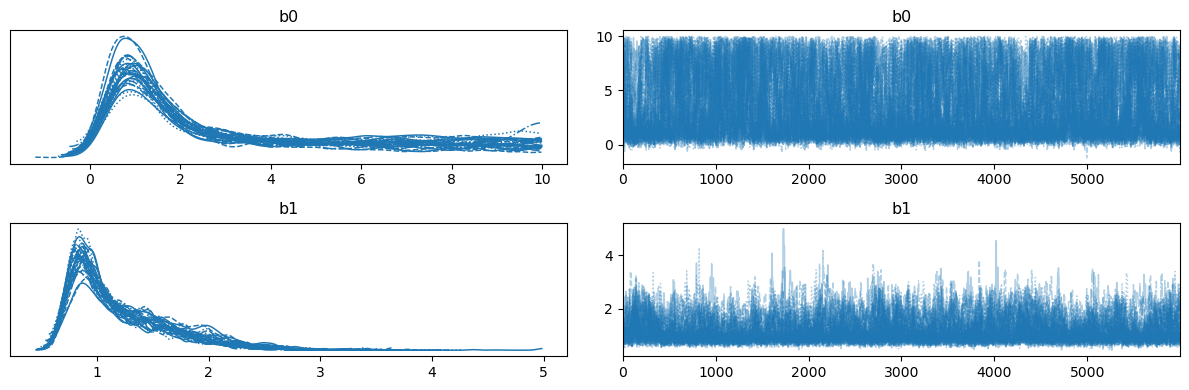

In [4]:
# 3) Bayesian left-truncated log–logistic POD via emcee (uniform priors)
# --------------------------------------------

# Priors: β0 ~ U[-20,20], β1 ~ U[0.01,20]
def log_prior(theta):
    b0, b1 = theta
    if (-10 <= b0 <= 10) and (0.01 <= b1 <= 10):
        return 0.0  # log(1) = 0
    return -np.inf

def log_likelihood(theta):
    b0, b1 = theta
    p = pod_left_trunc(x, b0, b1, alth=alth)
    p = np.clip(p, 1e-12, 1-1e-12)
    ll = y * n * np.log(p) + (1 - y) * n * np.log(1 - p)
    return np.sum(ll)

def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta)
    return lp + ll

# Sampler setup
ndim = 2
n_walkers = 32
# initialize walkers near MLE with small Gaussian noise
init_spread = np.array([0.1, 0.05])
p0 = np.array([b0_mle, b1_mle]) + init_spread * np.random.randn(n_walkers, ndim)

sampler = emcee.EnsembleSampler(n_walkers, ndim, log_posterior)

# Burn-in + production
burn = 2000
steps = 6000
_ = sampler.run_mcmc(p0, burn, progress=True)
sampler.reset()
_ = sampler.run_mcmc(None, steps, progress=True)

# Draws
chains = sampler.get_chain(flat=True)              # shape: [n_walkers*(steps), 2]
log_probs = sampler.get_log_prob(flat=True)
b0_s = chains[:, 0]
b1_s = chains[:, 1]
print(f"Mean accept frac: {np.mean(sampler.acceptance_fraction):.3f}")

# Posterior summaries
def summary(arr, name):
    q = np.percentile(arr, [2.5, 50, 97.5])
    print(f"{name:>6}: mean={np.mean(arr):.3f}, median={q[1]:.3f}, 95% CrI=({q[0]:.3f}, {q[2]:.3f})")

summary(b0_s, "β0")
summary(b1_s, "β1")

# --- Posterior POD bands on a grid ---
x_grid = np.linspace(max(alth, x.min()), x.max(), 400)
rng = np.random.default_rng(7)
ns = min(4000, len(b0_s))
sel = rng.choice(len(b0_s), size=ns, replace=False)

P = []
for j in sel:
    P.append(pod_left_trunc(x_grid, b0_s[j], b1_s[j], alth=alth))
P = np.vstack(P)  # [ns, len(x_grid)]

p_med = np.median(P, axis=0)
p_lo  = np.percentile(P, 5, axis=0)
p_hi  = np.percentile(P, 95, axis=0)

# --- a90 and a90/95 ---
# a90: median POD reaches 0.9
# a90/95: the 5th percentile band reaches 0.9 (i.e., lower 95% bound)
def x_at_level(p_series, x_grid, level=0.9):
    idx = np.where(p_series >= level)[0]
    if len(idx) == 0:
        return np.nan
    k = idx[0]
    if k == 0:
        return x_grid[0]
    # linear interpolate between k-1 and k
    x0, x1 = x_grid[k-1], x_grid[k]
    y0, y1 = p_series[k-1], p_series[k]
    t = (level - y0) / (y1 - y0 + 1e-12)
    return x0 + t * (x1 - x0)

a90_med = x_at_level(p_med, x_grid, 0.9)
a90_95  = x_at_level(p_lo,  x_grid, 0.9)
print(f"a90 (median POD=0.9):   {a90_med:.3f} mm")
print(f"a90/95 (lower 95% =0.9): {a90_95:.3f} mm")

labels = ["b0", "b1"]

# after sampling with emcee or similar:
idata = az.from_emcee(sampler, var_names=labels)

# Get summary with HDI = 95%
az.plot_trace(idata)
plt.tight_layout()
plt.show()

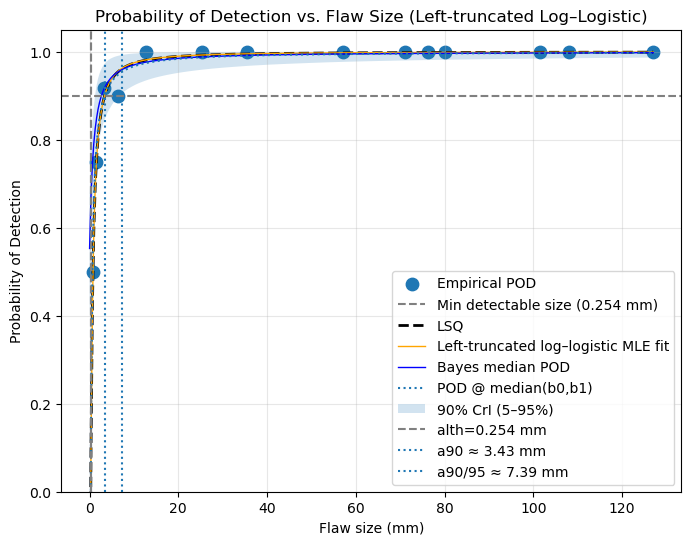

In [16]:
# 4) Parameter estimate validation visualization 
# ----------------------------------------------
x_grid = np.linspace(0, x.max(), 400)

p_grid = pod_left_trunc(x_grid, b0_mle, b1_mle, alth=alth)
p_grid_lsq = pod_left_trunc(x_grid, b0_lsq, b1_lsq, alth=alth)
b0_med = np.median(b0_s)
b1_med = np.median(b1_s)
p_at_param_medians = pod_left_trunc(x_grid, b0_med, b1_med, alth=alth)

plt.figure(figsize=(8,6))
plt.scatter(x, agg["p_detected"], s=80, color="tab:blue", label="Empirical POD")
plt.axvline(alth, color="gray", linestyle="--", label=f"Min detectable size ({alth} mm)")
plt.plot(x_grid, p_grid_lsq, color="black", lw=2, linestyle="--", label="LSQ")
plt.plot(x_grid, p_grid, color="orange", lw=1, label="Left-truncated log–logistic MLE fit")
plt.plot(x_grid, p_med, color="blue", lw=1, label="Bayes median POD")
plt.plot(x_grid, p_at_param_medians, label="POD @ median(b0,b1)", lw=1.5, linestyle=":")
plt.fill_between(x_grid, p_lo, p_hi, alpha=0.2, label="90% CrI (5–95%)")
plt.axhline(0.9, ls="--", color="gray")
plt.axvline(alth, ls="--", color="gray", label=f"alth={alth} mm")
if np.isfinite(a90_med): plt.axvline(a90_med, ls=":", label=f"a90 ≈ {a90_med:.2f} mm")
if np.isfinite(a90_95): plt.axvline(a90_95, ls=":", label=f"a90/95 ≈ {a90_95:.2f} mm")
plt.xlabel("Flaw size (mm)")
plt.ylabel("Probability of Detection")
plt.ylim(0,1.05)
plt.title("Probability of Detection vs. Flaw Size (Left-truncated Log–Logistic)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Answer
$$
\text{POD}(y \mid \beta_0, \beta_1) =
\begin{cases}
\dfrac{1}{1 + e^{-(\beta_0 + \beta_1 y)}}, & y \ge a_{\text{lth}} \\
0, & 0 < y < a_{\text{lth}}
\end{cases}
$$

where  

| Parameter | LSQ | MLE | BI |
|:-----------|:---:|:---:|:--:|
| $\beta_0$ | 1.036 | 0.983 | mean=3.285, median=2.026, 95% CrI=(0.169, 9.533) |
| $\beta_1$ | 1.298 | 1.323 | mean=1.190, median=1.047, 95% CrI=(0.662, 2.309) |